In [2]:
%matplotlib inline 
import os,sys,shutil,cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Rename and copy the dataset 

In [ ]:
# function
# todo 
def rename(old_prefix, new_prefix , dir, output_dir = None):
    
    # Rename the prefix
    # Renaming image names in directory <dir>, changing <old_prefix>* to <new_prefix>*
    # and saved in output_dir (default is None)
    # e.g. old_prefix is 'abc' and new_prefix is "cde"
    # Then a file 'abc_001.jpg' will be renamed as 'cde_001.jpg'
    
    if output_dir is None:
        output_dir = dir
    else:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    files = os.listdir(dir)
    for file in files:
        
        new_file = file.replace(old_prefix,new_prefix)
        os.rename(os.path.join(dir , file),
                  os.path.join(dir , new_file))

    old_prefix.replace(old_prefix,new_prefix)

    print(f"""
        Renamed the files in {dir}
        Changing old prefix {old_prefix} to new prefix {new_prefix}
        """)   


# To change here
old_prefix = "test"

new_prefix = "Bettongia_penicillata_all_sutures"

dir = "data_demo/change_prefix/img/"   
out_dir ="data_demo/change_prefix/img_changed/"   
   

rename(old_prefix, new_prefix , dir, out_dir)


In [ ]:
# function definition
def copy_imgs_masks(ori_dir: str ,  dst_dir :str, ref_dir: str):
    """Copy images in <ori_dir> that have the same file names as masks in <ref_dir> to <dst_dir>
    To create an  folder that matches the exact number of the name of the <ref_dir> folder.
    Args:
        ori_dir (str): original directory you want to move your files
        dst_dir (str): directory of your moved files
        ref_dir (str): The directory for the reference files that this funciton is based
    """
    Path(dst_dir).mkdir(parents=True, exist_ok=True)
    ref_files = os.listdir(ref_dir)
    

    
    files = os.listdir(ori_dir)
    
    for file in ref_files:
        assert file in files, "{} from {}is not in {}. Please check".format(file, ref_dir , ori_dir)
    for file in files:
        if file in ref_files:
            shutil.copyfile(os.path.join(ori_dir, file), os.path.join(dst_dir, file))
        
    print(f"""
        {len(ref_files)} files from {ori_dir} to {dst_dir} were copied
        """)   

# To change here
ori_dir = "data_demo/copy/img_all/"
dst_dir = "data_demo/copy/img/"

ref_dir = "data_demo/copy/mask/"

copy_imgs_masks(ori_dir ,  dst_dir , ref_dir)


In [ ]:
# Visualise the segmentation masks (pixel values from 1 to N)
# interpolate (0 to N) -> (0, 255)
# Reads in images from <mask_dir> and output visualised version in <vis_dir>



def visualise(dir , vis_dir):
    """ Visualise the segmentation masks (pixel values from 1 to N)
        interpolate (0 to N) -> (0, 255)
        Reads in images from <dir> and output visualised version in <vis_dir>

    Args:
        dir (_type_): folder of the mask you want to visulise
        vis_dir (_type_): the folder to save your visualised image
    """    
    Path(vis_dir).mkdir(parents=True, exist_ok=True)
    files = os.listdir(dir)
    for file in files:
        img = cv2.imread(os.path.join(dir , file), cv2.IMREAD_GRAYSCALE )
        cv2.imwrite(os.path.join(vis_dir,file), np.interp(img, [np.min(img), np.max(img)],[1,255]).astype('uint8')  )

    print(f"""
        {len(files)} Masks were visualised in {vis_dir}
        """)   


mask_dir = "data_demo/mask/"
vis_dir = "data_demo/visualised/"

visualise(mask_dir , vis_dir)

### Manipulations on the masks values
Combining multiple classes to one. (e.g. turn class 1,3 to class 1)

Update the values for the segmented classes

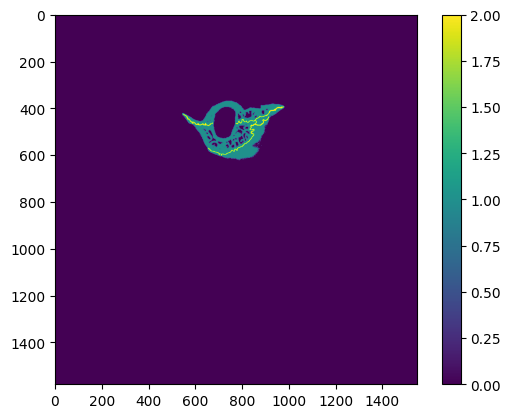

In [3]:
### Update the pixel values ###


def update_mask_values(mask_dir , new_dir , old_values, new_values,visual = False):
    """ update old values to new values. Its use cases：
            # 1. combine
            Processing origin masks 
            For example: transfer the masks from Dragonfly (1: bones, 2: suture, 3:background) to 
            masks that has only segmentation for suture and non-suture (1: non-suture and 2: suture)
            If user want to change the bones to the background (non sutures), which means all values of 1 are turned to 3
            They can define old_values as [1,2,3]. new_values as [3,2,3]
        
            # 2. update
            Default: Transfer the masks to the format of the pixel value starts from  (e.g. the first class is 0, the second class is 1, ... the n th class is n-1)
            If old_values and new_values are None, the code turns all the detected values to 0,1... n

            old_values =None
            new_values = None

            Specify the values:
            If old_values and new_values are specified, it code turns values from old values to the new values
            This example, turns sutures from dragonfly (1: bones, 2: suture, 3:background)  to 
            (0:background, 1: bones, 2: suture) 

    Args:
        mask_dir (_type_): folder of the input mask
        new_dir (_type_): folder of the new mask
        old_values (_type_): the old values of the mask
        new_values (_type_): the new values of the mask
        visual (bool) : If the visual is set True, it will plot the old and new versions of the last mask
    """    
    Path(new_dir).mkdir(parents=True, exist_ok=True)
    files = os.listdir(mask_dir)

    for file in files:
        mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
        if old_values is None or new_values is None:
            old_values = np.unique(mask)
            new_values = list(range(0, len(old_values)))
        

        mask_copy = mask.copy()
        for ov,nv in zip(old_values,new_values):
            mask[mask_copy==ov] = nv
            
        ov_value_check = 0    
        for ov in np.unique(old_values):
            ov_value_check += np.sum(mask_copy==ov)
        nv_value_check =0
        for nv in np.unique(new_values):
            nv_value_check += np.sum(mask==nv)
        assert nv_value_check== ov_value_check & nv_value_check ==(mask.shape[0] *mask.shape[1]) , "The pixel values transferred from old values \
                to new values are not matching, please check the value"
        # for ov,nv in zip(np.unique(old_values),np.unique(new_values)):
        #     assert np.sum(mask_copy==ov) == np.sum(mask==nv), "The pixel values transferred from old values \
        #         to new values are not matching, please check the value"
        
        cv2.imwrite(os.path.join(new_dir,file), mask)
            

    
    # If the visual is set True, it will plot the old and new versions of the last mask
    if visual:
        fig = plt.figure()
        fig.colorbar(plt.imshow(mask))
        fig = plt.figure()
        fig.colorbar(plt.imshow(mask_copy))


    print(f"""
        Masks were transferred from {old_values} to {new_values}
        And they are saved in: {new_dir}
        {len(files)} files were processed
        """)   
        

    
    
# mask_dir the directory for the origin masks, new_dir the directory for output masks
mask_dir = "data_demo/mask/"
new_dir= "data_demo/mask_bones/"

# If user want to change the bones to the background (non sutures), which means all values of 1 are turned to 3
# They can define old_values as [1,2,3]. new_values as [3,2,3]



# Plot a mask from the directory and show the value for each segmentation class in the colourbar

file = os.listdir(mask_dir)[0]
mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
plt.colorbar(plt.imshow(mask))


old_values = [0,1,2]
new_values = [0,1,0]

# mask_dir = "data/training_suture/mask_ori/"
# new_dir= "data/training_suture/mask/"


# # Specify the values:
# # If old_values and new_values are specified, it code turns values from old values to the new values
# # This example, turns sutures from dragonfly (1: bones, 2: suture, 3:background)  to 
# # (0:background, 1: bones, 2: suture) 
# old_values = [1,2,3]
# new_values = [1,2,0]

# update_mask_values(mask_dir , new_dir , old_values, new_values)

In [ ]:
update_mask_values(mask_dir , new_dir , old_values, new_values)

### Clean the masks

In [ ]:
# function
def clean_masks(mask_dir , new_dir, mask_value, value_for_noises = 0, visual = False):
    """### Processing masks, Use open and close to remove noises.
        ## Cleaning the noises of the suture masks generated from the dragonfly,

    Args:
        mask_dir (_type_): folder of the input mask
        new_dir (_type_): the directory of the cleaned masks
        mask_value: the segmentation you want to smooth (e.g. if value=1, it means the first class of the segmentation)
        value_for_noises: the value you want to assign the removed noise to. The default value is 0
        visual (bool, optional): If the visual is set True, it will plot the old and new versions of the last mask. Defaults to False.
    """    
    Path(new_dir).mkdir(parents=True, exist_ok=True)
    files = os.listdir(mask_dir)
    noise_pixels = 0
    for file in files:
        # print(file)
        img = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
        img_ori = img.copy()

        mask = (img==mask_value).astype('uint8')
  
        
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        value_for_noises += np.sum(np.logical_xor(opening , img==mask_value) )
        
        
        all_seg_values = np.unique(img)
        rest_seg_values = np.setdiff1d(all_seg_values, np.array([mask_value,value_for_noises]))

        
        for rest_seg_value in rest_seg_values:
            opening = opening | (img==rest_seg_value)
        
        img[opening==value_for_noises]=value_for_noises
        
        
        assert np.all(np.isin(img, all_seg_values)) , "Mask value not matching"
        
      
        
        # # Turn 3: background to 1: non-suture
        # img[img==3]=2

        cv2.imwrite(os.path.join(new_dir,file), img)


    # If the visual is set True, it will plot the old and new versions of the last mask
    if visual:
        fig = plt.figure()
        fig.colorbar(plt.imshow(img_ori))
        fig = plt.figure()
        fig.colorbar(plt.imshow(img))

    print(f"""
        Cleaning the noises of masks in {mask_dir}
        And they are saved in: {new_dir}
        {len(files)} files were processed
        Average {value_for_noises/len(files)} pixels were removed per image
        """)   
    

# To change
# mask_dir: the directory of the masks
# new_dir: the directory of the cleaned masks
mask_dir = "data_demo/mask/"
new_dir = "data_demo/mask_clean/"

clean_masks(mask_dir , new_dir , mask_value=1, visual = True)

### Crop and pad images and masks

In [ ]:
# function definition

def crop_img_mask(img_dir , mask_dir, img_crop_dir, mask_crop_dir,background_value = 0, visual = False):
    """## Cropping the images and masks to have better focus on the object
        ## Crop to the non-background area
        ## Use the min/max x and min/max y of bones or sutures of the masks as the cropping coordinate

    Args:
        img_dir (_type_): the directory of the images
        mask_dir (_type_): the directory of the masks
        img_crop_dir (_type_): the directory for the cropped images
        mask_crop_dir (_type_): the directory for the cropped images
        background_value : the value of the background, the default is 0
        visual (bool, optional): If the visual is set True, it will plot the old and new versions of the last mask. Defaults to False.
    """
    Path(img_crop_dir).mkdir(parents=True, exist_ok=True)
    Path(mask_crop_dir).mkdir(parents=True, exist_ok=True)
    #

    files = os.listdir(mask_dir)
    for file in files:
        # print(file)
        
        mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
        mask_ori = mask.copy()
        # get the index of bones or sutures
        # first array is the row (img height) and the second array is the col (img width)
        
        non_background_values = np.setdiff1d(np.unique(mask), background_value)
        row_id, col_id = np.where(np.isin(mask, non_background_values))
        # row_id, col_id = np.where((mask == 1) | (mask == 2))

        min_h = np.min(row_id)
        max_h = np.max(row_id)

        min_w = np.min(col_id)
        max_w = np.max(col_id)

        mask = mask[min_h:max_h+1 ,min_w:max_w+1]
        cv2.imwrite(os.path.join(mask_crop_dir,file), mask)

        img = cv2.imread(os.path.join(img_dir , file), cv2.IMREAD_GRAYSCALE )
        img_ori = img.copy()

        img = img[min_h:max_h+1 ,min_w:max_w+1]
        cv2.imwrite(os.path.join(img_crop_dir,file), img)

    # If the visual is set True, it will plot the original and cropped images and masks.
    if visual:
        fig = plt.figure()
        plt.subplot(2, 2, 1)
        plt.imshow(img_ori)
        
        plt.subplot(2, 2, 2)
        plt.imshow(mask_ori)

        plt.subplot(2, 2, 3)
        plt.imshow(img)
        
        plt.subplot(2, 2, 4)
        plt.imshow(mask)
        


    print(f"""
        Images and masks from {img_dir} and {mask_dir} are cropped
        And they are saved in: {img_crop_dir} and {mask_crop_dir}
        {len(files)} files were processed
        """)   
    
    
# **To change** to fit your dataset
# img_dir: the directory of the imgs
# mask_dir: the directory of the masks

# img_crop_dir: the directory for the cropped images
# mask_crop_dir: the directory for the cropped images
img_dir = "data_demo/img/"
mask_dir = "data_demo/mask/"

img_crop_dir = "data_demo/img_crop/"
mask_crop_dir= "data_demo/mask_crop/"

# Set the background (or the non focal value)
background_value = 0

crop_img_mask(img_dir , mask_dir, img_crop_dir, mask_crop_dir , background_value = background_value , visual = True)

In [ ]:
# def function
def padding(img_dir, mask_dir, pad_img_dir , pad_mask_dir ,background_value = 0 , visual = False):
    """### Padding the images to the largest resolution ###
        # The training set 1.0 's largest resolution is 1681 x 1820
        # padding both training images and masks
        # The current padding method make the original image as the center

    Args:
        img_dir (_type_): the directory of the images
        mask_dir (_type_): the directory of the masks
        img_crop_dir (_type_): the directory for the cropped images
        mask_crop_dir (_type_): the directory for the cropped images
        visual (bool, optional): If the visual is set True, it will plot the old and new versions of the last mask. Defaults to False.
    """
    Path(pad_img_dir).mkdir(parents=True, exist_ok=True)
    Path(pad_mask_dir).mkdir(parents=True, exist_ok=True)

    files = os.listdir(img_dir)

    width = 0
    height = 0

    for file in files:
        ## Read, pad and write images
        img = cv2.imread(os.path.join(img_dir , file), cv2.IMREAD_GRAYSCALE )
        mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
        h1,w1 = img.shape
        
        h2,w2 = mask.shape
        
        if h1>height:
            height = h1
        if h2>height:
            height = h2

        
        if w1>width:
            width = w1
        if w2>width:
            width = w2



    for file in files:
        ## Read, pad and write images
        img = cv2.imread(os.path.join(img_dir , file), cv2.IMREAD_GRAYSCALE )
        
        w = img.shape[1]
        h = img.shape[0]
        w_diff = width - w
        h_diff = height - h

        # print(f'''image width {w} and height {h}''')

        padding_colour = [background_value]*3
        dst = cv2.copyMakeBorder(img , h_diff//2, h_diff - (h_diff//2),
                                w_diff//2 ,w_diff -(w_diff//2),cv2.BORDER_CONSTANT,None,
                                padding_colour )
        # print(f'''new image shape {dst.shape} ''')

        cv2.imwrite(os.path.join(pad_img_dir , file) , dst)
        
        ## read, pad and write masks
        mask = cv2.imread(os.path.join(mask_dir , file), cv2.IMREAD_GRAYSCALE )
        
        w = mask.shape[1]
        h = mask.shape[0]
        w_diff = width - w
        h_diff = height - h

        # print(f'''image width {w} and height {h}''')

        dst_mask = cv2.copyMakeBorder(mask , h_diff//2, h_diff - (h_diff//2),
                                w_diff//2 ,w_diff -(w_diff//2),cv2.BORDER_CONSTANT,None,
                                0 )
        # print(f'''new image shape {dst.shape} ''')

        cv2.imwrite(os.path.join(pad_mask_dir , file) , dst_mask)


    
    # If the visual is set True, it will plot the original and cropped images and masks.
    if visual:
        fig = plt.figure()
        
        plt.subplot(2, 2, 1)
        plt.imshow(img)
        
        plt.subplot(2, 2, 2)
        plt.imshow(mask)
        
        plt.subplot(2, 2, 3)
        plt.imshow(dst)
        
        plt.subplot(2, 2, 4)
        plt.imshow(dst_mask)


    print(f"""
        Images and masks from {img_dir} and {mask_dir} are padded to {width} x {height}
        And they are saved in: {pad_img_dir} and {pad_mask_dir}
        {len(files)} files were processed
        """)    

img_dir = "data_demo/img_crop/"
mask_dir = "data_demo/mask_crop/"

pad_img_dir = "data_demo/img_crop_pad/"
pad_mask_dir = "data_demo/mask_crop_pad"

padding(img_dir, mask_dir, pad_img_dir , pad_mask_dir , visual = False)